#### Importing the Libraries

In [1]:
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

#### Reading the dataset

In [2]:
df_fx_data = pd.read_csv('BOE-XUDLERD.csv')
df_fx_data.head()

,Date,Value
0,2017-11-09,0.8603
1,2017-11-08,0.8631
2,2017-11-07,0.8639
3,2017-11-06,0.8631
4,2017-11-03,0.8608


In [3]:
df_fx_data.shape

(10837, 2)

In [4]:
df_fx_data['Date'] = pd.to_datetime(df_fx_data['Date'])
indexed_df = df_fx_data.set_index('Date')

In [5]:
indexed_df.head()

,Value
Date,
2017-11-09,0.8603
2017-11-08,0.8631
2017-11-07,0.8639
2017-11-06,0.8631
2017-11-03,0.8608


In [6]:
# Create a pandas series of the actual data
ts = indexed_df['Value']
ts.head(5)

Date
2017-11-09    0.8603
2017-11-08    0.8631
2017-11-07    0.8639
2017-11-06    0.8631
2017-11-03    0.8608
Name: Value, dtype: float64

In [7]:
print(type(ts))
print(ts.shape)

<class 'pandas.core.series.Series'>
(10837,)


#### Plotting the Time Series data

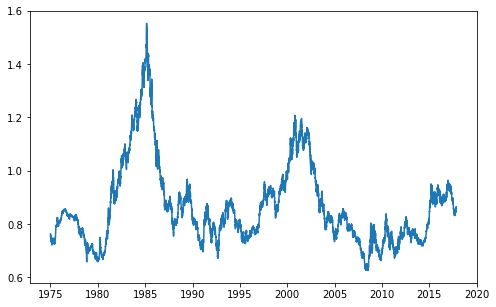

In [9]:
plt.figure(figsize=(8,5))
plt.plot(ts)

#### Lets resample the data to Weekly basis

In [11]:
ts_week = ts.resample('W').mean()
print(ts_week.shape)
ts_week.head()

(2237,)


Date
1975-01-05    0.76090
1975-01-12    0.75346
1975-01-19    0.75546
1975-01-26    0.74388
1975-02-02    0.73902
Freq: W-SUN, Name: Value, dtype: float64

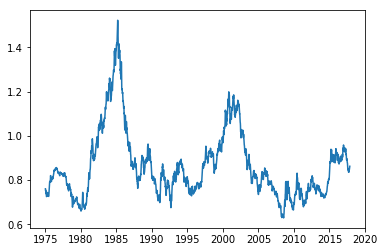

In [12]:
plt.plot(ts_week)

### Test for Stationarity using the DF Test

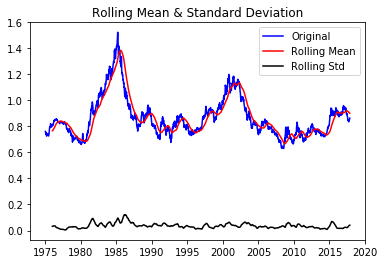

Results of Dickey-Fuller Test:
Test Statistic                   -2.076341
p-value                           0.254134
#Lags Used                        2.000000
Number of Observations Used    2234.000000
Critical Value (1%)              -3.433281
Critical Value (5%)              -2.862835
Critical Value (10%)             -2.567459
dtype: float64


In [13]:
def test_stationarity(timeseries):
    #Determing rolling statistics (Timeframe 1 year)
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
#     print(dftest)
#     print()
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

# We will now use the above created function to check if our data is stationary
test_stationarity(ts_week)

##### The `p-value` is larger than 5%. Null hypothesis stands and the data is not stationary.

#### We need to make this into a stationary timeseries data before we can use ARIMA  model by differentiating

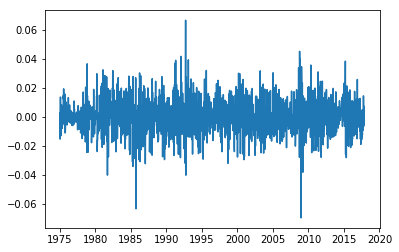

In [14]:
ts_week_log = np.log(ts_week)
ts_week_log_diff = ts_week_log - ts_week_log.shift()
plt.plot(ts_week_log_diff)

In [29]:
ts_week_log_diff.head()

Date
1975-01-12   -0.009826
1975-01-19    0.002651
1975-01-26   -0.015447
1975-02-02   -0.006555
1975-02-09    0.013494
Freq: W-SUN, Name: Value, dtype: float64

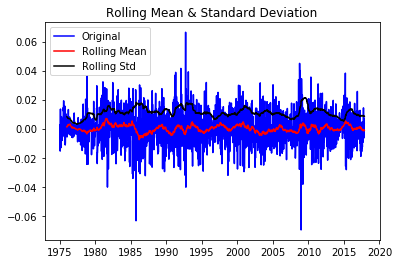

Results of Dickey-Fuller Test:
Test Statistic                  -36.590004
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    2235.000000
Critical Value (1%)              -3.433279
Critical Value (5%)              -2.862834
Critical Value (10%)             -2.567459
dtype: float64


In [15]:
ts_week_log_diff.dropna(inplace=True)

# Now use the same function to check for stationarity in the timeseries data
test_stationarity(ts_week_log_diff)

##### we need to find the values of p and q

In [15]:
#ACF (q) and PACF (p)
lag_acf = acf(ts_week_log_diff, nlags=10)
lag_pacf = pacf(ts_week_log_diff, nlags=10, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

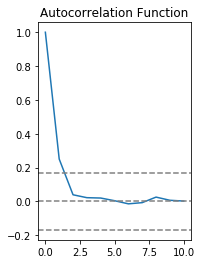

In [16]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

##### We are looking for the x for which the graph first crosses the upper boundary. We can see q = 1

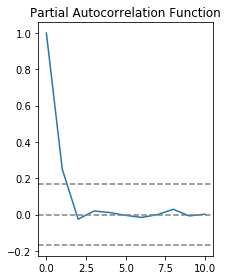

In [17]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

##### We are looking for the x for which the graph first dips down the zero line. Here p = 2

Text(0.5, 1.0, 'RSS: 0.2806')

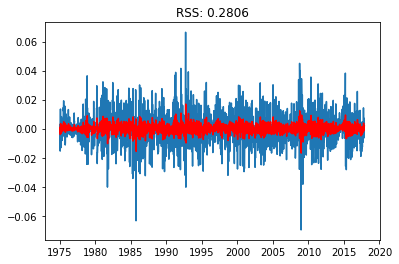

In [18]:
model = ARIMA(ts_week_log, order=(2, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_week_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_week_log_diff)**2))

##### Plot of the residuals

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                 2236
Model:                 ARIMA(2, 1, 1)   Log Likelihood                6870.601
Method:                       css-mle   S.D. of innovations              0.011
Date:                Tue, 22 Jan 2019   AIC                         -13731.202
Time:                        08:28:27   BIC                         -13702.640
Sample:                    01-12-1975   HQIC                        -13720.773
                         - 11-12-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           5.51e-05      0.000      0.178      0.859      -0.001       0.001
ar.L1.D.Value    -0.0901      0.487     -0.185      0.853      -1.044       0.864
ar.L2.D.Value     0.0602      0.128     

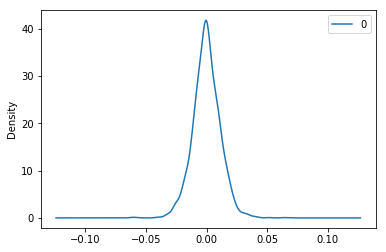

In [19]:
print(results_ARIMA.summary())
# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

#### Predictions of ARIMA

In [20]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Date
1975-01-12    0.000055
1975-01-19   -0.002420
1975-01-26    0.000987
1975-02-02   -0.004103
1975-02-09   -0.001134
Freq: W-SUN, dtype: float64


#### Converting to antilog

##### Remove the first order differencing and take exponent to restore the prediction back to their original state

C:\Users\tusha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Text(0.5, 1.0, 'RMSE: 0.1353')

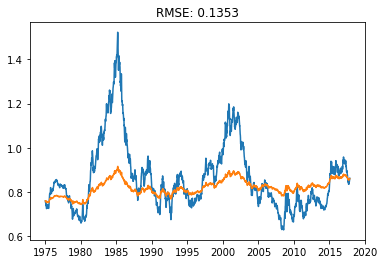

In [21]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_week_log.ix[0], index=ts_week_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts_week)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts_week)**2)/len(ts_week)))

In [22]:
size = int(len(ts_week_log) - 15)
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()

In [23]:
size = int(len(ts_week_log) - 15)
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()
print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

Printing Predicted vs Expected Values...


predicted=0.860853, expected=0.862600


In [24]:
error = mean_squared_error(test, predictions)
print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)
predictions_series = pd.Series(predictions, index = test.index)



Printing Mean Squared Error of Predictions...
Test MSE: 0.000043


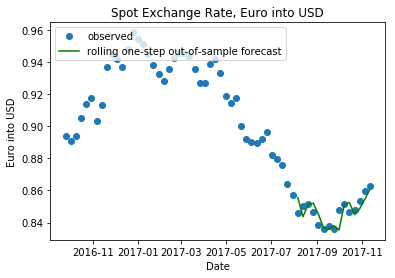

In [25]:
fig, ax = plt.subplots()
ax.set(title='Spot Exchange Rate, Euro into USD', xlabel='Date', ylabel='Euro into USD')
ax.plot(ts_week[-60:], 'o', label='observed')
ax.plot(np.exp(predictions_series), 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')